
# 📚 Book Cover Classifier


In [ ]:
!pip -q install kagglehub pillow pandas scikit-learn tensorflow

import os
import math
import json
import time
import random
import shutil
import zipfile
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import requests

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

import kagglehub
from kagglehub import KaggleDatasetAdapter

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]



## 2) Load the dataset CSV from Kaggle

In [ ]:

# ===================================================
# 2) Load the dataset (books_data.csv) via kagglehub
# ===================================================
save_dir = Path("dataset")
save_dir.mkdir(parents=True, exist_ok=True)

file_name = "books_data.csv"
print(f"Loading {file_name} from KaggleHub...")
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "mohamedbakhet/amazon-books-reviews",
    file_name,
)
csv_path = save_dir / file_name
df.to_csv(csv_path, index=False)
print(f"Saved {file_name} to {csv_path}")
print(df.head())
print("Columns:", list(df.columns))


Loading books_data.csv from KaggleHub...


/tmp/ipython-input-121264283.py:9: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


Saved books_data.csv to dataset/books_data.csv
                                               Title  \
0                     Its Only Art If Its Well Hung!   
1                           Dr. Seuss: American Icon   
2              Wonderful Worship in Smaller Churches   
3                      Whispers of the Wicked Saints   
4  Nation Dance: Religion, Identity and Cultural ...   

                                         description              authors  \
0                                                NaN     ['Julie Strain']   
1  Philip Nel takes a fascinating look into the k...       ['Philip Nel']   
2  This resource includes twelve principles in un...     ['David R. Ray']   
3  Julia Thomas finds her life spinning out of co...  ['Veronica Haddon']   
4                                                NaN      ['Edward Long']   

                                               image  \
0  http://books.google.com/books/content?id=DykPA...   
1  http://books.google.com/books/content?


## 3) Pick the image URL and category columns


In [ ]:

# Try to detect the right columns
possible_image_cols = ["image"]
possible_cat_cols   = ["categories"]

img_col = None
for c in possible_image_cols:
    if c in df.columns:
        img_col = c
        break

cat_col = None
for c in possible_cat_cols:
    if c in df.columns:
        cat_col = c
        break

if img_col is None:
    raise ValueError("Could not find an image URL column in the CSV.")

if cat_col is None:
    # Fallback: sometimes category-like info is in 'authors' or 'publisher' etc.
    # For the purposes of this student project, we'll try 'authors' as a weak proxy.
    # But if it doesn't exist, we stop.
    for fallback in ["authors", "Authors", "publisher", "Publisher"]:
        if fallback in df.columns:
            cat_col = fallback
            print(f"Warning: Using fallback category column: {cat_col}")
            break

if cat_col is None:
    raise ValueError("Could not find a category-like column. Please inspect df.columns and adjust.")

print("Using image column:", img_col)
print("Using category column:", cat_col)


Using image column: image
Using category column: categories



## 4) Clean data and make a **small balanced sample** (fast to run)

- Keep rows where image URL and category are valid (non-empty)
- Choose a few categories with many images (e.g., top 3)
- Sample a small number per class (e.g., 40 per class → ~120 total)


In [ ]:

# Basic cleaning
clean = df[[img_col, cat_col]].dropna()
clean = clean[clean[img_col].astype(str).str.startswith(("http://", "https://"))]
clean = clean[clean[cat_col].astype(str).str.strip() != ""]

# Choose categories with the most images
top_classes = (
    clean[cat_col]
    .value_counts()
    .head(6) # consider top 6 first
    .index
    .tolist()
)

# We'll filter to the first 3 classes that have at least 50 images (so we can sample)
selected_classes = []
for c in top_classes:
    cnt = (clean[cat_col] == c).sum()
    if cnt >= 50:
        selected_classes.append(c)
    if len(selected_classes) == 15:
        break

# If we couldn't find 3 classes with >=50, relax the threshold
if len(selected_classes) < 3:
    selected_classes = top_classes[:3]

print("Selected classes:", selected_classes)

sample_per_class = 400  # keep it small for Colab speed
sampled_list = []
for c in selected_classes:
    subset = clean[clean[cat_col] == c].sample(min(sample_per_class*2, len(clean[clean[cat_col] == c])), random_state=42)  # oversample to survive bad URLs
    sampled_list.append(subset)

sampled = pd.concat(sampled_list).reset_index(drop=True)
print("Sampled rows (before URL validation):", len(sampled))
sampled.head(10)
sampled.tail(10)


Selected classes: ["['Fiction']", "['Religion']", "['History']", "['Juvenile Fiction']", "['Biography & Autobiography']", "['Business & Economics']"]
Sampled rows (before URL validation): 4800


,image,categories
4790,http://books.google.com/books/content?id=6nfGS...,['Business & Economics']
4791,http://books.google.com/books/content?id=BPnQD...,['Business & Economics']
4792,http://books.google.com/books/content?id=m44cA...,['Business & Economics']
4793,http://books.google.com/books/content?id=iInjD...,['Business & Economics']
4794,http://books.google.com/books/content?id=MXt4y...,['Business & Economics']
4795,http://books.google.com/books/content?id=gbdE3...,['Business & Economics']
4796,http://books.google.com/books/content?id=b46PQ...,['Business & Economics']
4797,http://books.google.com/books/content?id=KI-rG...,['Business & Economics']
4798,http://books.google.com/books/content?id=yjm46...,['Business & Economics']
4799,http://books.google.com/books/content?id=MZxIA...,['Business & Economics']



## 5) Download images and keep only valid ones

We'll download images to a folder and skip broken URLs.  


In [ ]:

import shutil
from pathlib import Path
import requests

def download_image(url, path, timeout=8):
    try:
        r = requests.get(url, timeout=timeout, stream=True)
        if r.status_code == 200 and "image" in r.headers.get("Content-Type", ""):
            with open(path, "wb") as f:
                for chunk in r.iter_content(1024):
                    f.write(chunk)
            return True
        return False
    except Exception as e:
        return False

raw_dir = Path("raw_images")
if raw_dir.exists():
    shutil.rmtree(raw_dir)
raw_dir.mkdir(parents=True, exist_ok=True)

kept_rows = []
for i, row in sampled.iterrows():
    url = str(row[img_col])
    cat = str(row[cat_col]).strip().replace("/", "-")  # avoid folder issues
    img_path = raw_dir / f"{i}.jpg"
    ok = download_image(url, img_path)
    if ok:
        kept_rows.append({"path": str(img_path), "category": cat})
    if (i+1) % 50 == 0:
        print(f"Checked {i+1}/{len(sampled)}")

kept = pd.DataFrame(kept_rows)
print("Valid images downloaded:", len(kept))
kept.head()


Checked 50/4800
Checked 100/4800
Checked 150/4800
Checked 200/4800
Checked 250/4800
Checked 300/4800
Checked 350/4800
Checked 400/4800
Checked 450/4800
Checked 500/4800
Checked 550/4800
Checked 600/4800
Checked 650/4800
Checked 700/4800
Checked 750/4800
Checked 800/4800
Checked 850/4800
Checked 900/4800
Checked 950/4800
Checked 1000/4800
Checked 1050/4800
Checked 1100/4800
Checked 1150/4800
Checked 1200/4800
Checked 1250/4800
Checked 1300/4800
Checked 1350/4800
Checked 1400/4800
Checked 1450/4800
Checked 1500/4800
Checked 1550/4800
Checked 1600/4800
Checked 1650/4800
Checked 1700/4800
Checked 1750/4800
Checked 1800/4800
Checked 1850/4800
Checked 1900/4800
Checked 1950/4800
Checked 2000/4800
Checked 2050/4800
Checked 2100/4800
Checked 2150/4800
Checked 2200/4800
Checked 2250/4800
Checked 2300/4800
Checked 2350/4800
Checked 2400/4800
Checked 2450/4800
Checked 2500/4800
Checked 2550/4800
Checked 2600/4800
Checked 2650/4800
Checked 2700/4800
Checked 2750/4800
Checked 2800/4800
Checked 2850

,path,category
0,raw_images/0.jpg,['Fiction']
1,raw_images/1.jpg,['Fiction']
2,raw_images/2.jpg,['Fiction']
3,raw_images/3.jpg,['Fiction']
4,raw_images/4.jpg,['Fiction']



## 6) Make train/val/test splits (folder structure)

We'll split **70/15/15** and arrange images like:
```
data/
  train/<class>/*.jpg
  val/<class>/*.jpg
  test/<class>/*.jpg
```
This works nicely with `tf.keras.utils.image_dataset_from_directory`.


In [ ]:

import numpy as np

def split_and_copy(df, root="data", seed=42):
    root = Path(root)
    if root.exists():
        shutil.rmtree(root)
    for split in ["train", "val", "test"]:
        (root/split).mkdir(parents=True, exist_ok=True)

    rng = np.random.default_rng(seed)
    classes = sorted(df["category"].unique())
    for c in classes:
        sub = df[df["category"] == c].sample(frac=1.0, random_state=seed)  # shuffle
        n = len(sub)
        n_train = int(0.7 * n)
        n_val   = int(0.15 * n)
        # rest to test
        train_idx = sub.index[:n_train]
        val_idx   = sub.index[n_train:n_train+n_val]
        test_idx  = sub.index[n_train+n_val:]

        for split, idxs in [("train", train_idx), ("val", val_idx), ("test", test_idx)]:
            out_dir = root/split/c
            out_dir.mkdir(parents=True, exist_ok=True)
            for idx in idxs:
                src = sub.loc[idx, "path"]
                base = Path(src).name  # keep the same filename
                dst = out_dir / base
                shutil.copy(src, dst)

split_and_copy(kept, root="data")
!find data -maxdepth 2 -type d -print


data
data/train
data/train/['Religion']
data/train/['History']
data/train/['Juvenile Fiction']
data/train/['Biography & Autobiography']
data/train/['Business & Economics']
data/train/['Fiction']
data/val
data/val/['Religion']
data/val/['History']
data/val/['Juvenile Fiction']
data/val/['Biography & Autobiography']
data/val/['Business & Economics']
data/val/['Fiction']
data/test
data/test/['Religion']
data/test/['History']
data/test/['Juvenile Fiction']
data/test/['Biography & Autobiography']
data/test/['Business & Economics']
data/test/['Fiction']



## 7) Build TensorFlow datasets

We'll use `image_dataset_from_directory` with small images (160x160) for speed.


In [ ]:

import tensorflow as tf

IMG_SIZE = (160, 160)
BATCH_SIZE = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    "data/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True,
    seed=42,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "data/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "data/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 3360 files belonging to 6 classes.
Found 720 files belonging to 6 classes.
Found 720 files belonging to 6 classes.
Classes: ["['Biography & Autobiography']", "['Business & Economics']", "['Fiction']", "['History']", "['Juvenile Fiction']", "['Religion']"]



## 8) CNN using transfer learning (MobileNetV2)

- Freeze the base model first (faster, less overfitting)
- Add simple data augmentation
- We'll try a **couple learning rates** to pick what works best (mini model selection)


In [ ]:

from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)

model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


## 9) Tiny hyperparameter search (learning rate)

We'll try **two learning rates** for the Adam optimizer and pick the one with better validation accuracy.


In [ ]:

def compile_and_train(lr):
    m = models.clone_model(model)
    m.set_weights(model.get_weights())
    m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    cb = [
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy")
    ]
    history = m.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        verbose=1,
        callbacks=cb
    )
    best_val_acc = max(history.history["val_accuracy"])
    return m, best_val_acc, history

lrs = [1e-3, 3e-4]  # small search
results = []
best_model = None
best_acc = -1
best_lr = None

for lr in lrs:
    print(f"\n=== Training with LR={lr} ===")
    m, val_acc, hist = compile_and_train(lr)
    results.append((lr, val_acc))
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = m
        best_lr = lr

print("LR search results:", results)
print(f"Best LR: {best_lr} with val_acc={best_acc:.4f}")



=== Training with LR=0.001 ===
Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.2768 - loss: 1.9297 - val_accuracy: 0.3847 - val_loss: 1.5859
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4224 - loss: 1.5174 - val_accuracy: 0.3958 - val_loss: 1.5786
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.4525 - loss: 1.4320 - val_accuracy: 0.3986 - val_loss: 1.5542
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.4689 - loss: 1.3826 - val_accuracy: 0.4083 - val_loss: 1.5403
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4715 - loss: 1.3524 - val_accuracy: 0.4139 - val_loss: 1.5199
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.4982 - loss: 1.3111 - val_accuracy: 0.4097 - val_loss: 1.5540
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5102 - loss: 1.2587 - val_accuracy: 0.4069 - val_loss: 1.5355
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy


## 10)Quick fine-tuning

Unfreeze the top layers of MobileNetV2 to fine-tune a bit (very few epochs).


In [ ]:

base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr * 0.5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

ft_history = best_model.fit(
    train_ds, validation_data=val_ds, epochs=3, verbose=1
)


Epoch 1/3
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.5099 - loss: 1.2854 - val_accuracy: 0.4236 - val_loss: 1.5230
Epoch 2/3
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5151 - loss: 1.2660 - val_accuracy: 0.4250 - val_loss: 1.5156
Epoch 3/3
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5192 - loss: 1.2384 - val_accuracy: 0.4153 - val_loss: 1.5333



## 11) Evaluate on the **test** set (generalization)


In [ ]:

test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")


Test accuracy: 0.3972



## 12) Confusion matrix & classification report


Confusion matrix:
 [[43  9 28 14  6 20]
 [ 4 67 16  6  4 23]
 [13 17 51 12 15 12]
 [22 21 21 29  5 22]
 [ 9  5 23  7 69  7]
 [12 36 22 13 10 27]]


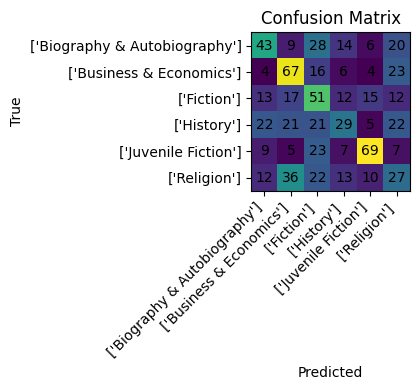

                               precision    recall  f1-score   support

['Biography & Autobiography']       0.42      0.36      0.39       120
     ['Business & Economics']       0.43      0.56      0.49       120
                  ['Fiction']       0.32      0.42      0.36       120
                  ['History']       0.36      0.24      0.29       120
         ['Juvenile Fiction']       0.63      0.57      0.60       120
                 ['Religion']       0.24      0.23      0.23       120

                     accuracy                           0.40       720
                    macro avg       0.40      0.40      0.39       720
                 weighted avg       0.40      0.40      0.39       720



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

y_true = []
y_pred = []
for images, labels in test_ds:
    preds = best_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Get class names from the original dataset before caching/prefetching
# class_names is already defined from the original train_ds
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm)
ax.set_xticks(range(len(class_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))


## 13) Save the model & try a quick prediction


Saved model to book_cover_mobilenetv2.h5


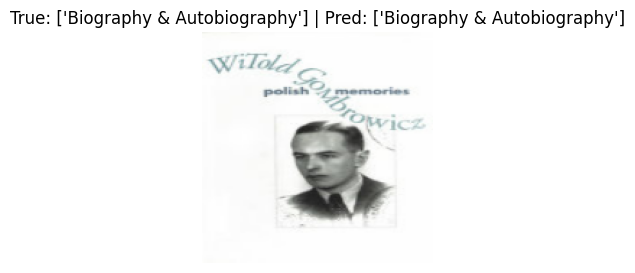

Predicted probabilities: [0.86506385 0.0042755  0.01869754 0.05412822 0.04938504 0.00844993]


In [ ]:

best_model.save("book_cover_mobilenetv2.h5")
print("Saved model to book_cover_mobilenetv2.h5")

for images, labels in test_ds.take(1):
    img = images[0:1]
    true_idx = int(np.argmax(labels[0].numpy()))
    probs = best_model.predict(img, verbose=0)[0]
    pred_idx = int(np.argmax(probs))

    plt.figure(figsize=(3,3))
    plt.imshow(img[0].numpy().astype("uint8"))
    plt.title(f"True: {class_names[true_idx]} | Pred: {class_names[pred_idx]}")
    plt.axis("off")
    plt.show()

    print("Predicted probabilities:", probs)
    break
